# Calculating PM2.5 exposure and health impacts using https://inmap.run

This notebook goes through some examples of how the EIEIO model hosted at https://inmap.run can be used to calculate population-weighted concentrations (e.g., exposure) and health impacts caused by emissions of PM2.5 and its precursors.

The website exposes a [gRPC](https://grpc.io/) service which we can interact with using a number of different languages. The example here uses Python; other notable options are Go and Javascript.

The available functionality is defined in the `eieio.proto` file which is in the same directory as this notebook, but there is not currently much documentation in that file regarding what the different functions do. Instead, documentation can be found in the server source code [here](https://godoc.org/github.com/spatialmodel/inmap/emissions/slca/eieio).

## Setup

Import the necessary libraries. The eieio_pb* ones have been automatically generated from `eieio.proto`, our RPC service definition.

In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..')) # Allow importing modules in parent directory.
import eieio_pb2_grpc # This module is in the parent directory.
import eieio_pb2 # This module is in the parent directory.
import grpc
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.collections import PatchCollection

#### Connect to the server at https://inmap.run.

In [2]:
creds = grpc.ssl_channel_credentials()
channel = grpc.secure_channel('inmap.run:443', creds)
stub = eieio_pb2_grpc.EIEIOrpcStub(channel)

## Health impacts

#### Calculate total deaths

In [3]:
totalDeaths = stub.EvaluationHealth(eieio_pb2.EvaluationHealthInput(
    Year = 2015,
    Pollutant = eieio_pb2.TotalPM25,
    Population = "all",
    HR = "NasariACS",
)) # The result here is an array of deaths in each InMAP grid cell.

In [4]:
print("Total Deaths:", np.array(totalDeaths.Data).sum())

Total Deaths: 131002.862263


#### Calculation deaths caused by emitter group

In [5]:
groupDeaths = stub.EmitterGroups(eieio_pb2.Selection(
    EndUseGroup =      "All",
    EndUseSector =     "All",
    EmitterGroup =  "All",
    EmitterSector = "All",
    ImpactType =       "health",
    Population =       "all",
    FinalDemandType =  eieio_pb2.AllDemand,
    Year =             2015,
    Pollutant =        eieio_pb2.TotalPM25,
))

In [6]:
pd.DataFrame({"Group":groupDeaths.Names, "Deaths/year":groupDeaths.Values})

,Group,Deaths/year
0,All,102183.679688
1,Industrial,21317.546875
2,Agriculture,14761.374023
3,Light Duty Gas Veh.,10132.916016
4,Coal Elec. Util.,9427.892578
5,Heavy Duty Diesel Veh.,8546.149414
6,Off-Highway Veh. & Equip.,7480.958008
7,Miscellaneous,5973.722656
8,Construction,5268.229492
9,Residential Wood Comb.,5105.409180


In [7]:
print("Biogenic and wildfire deaths:", np.array(totalDeaths.Data).sum() - groupDeaths.Values[0])

Biogenic and wildfire deaths: 28819.1825759


## Population-weighted concentrations (Exposure)

In [8]:
demand = stub.FinalDemand(eieio_pb2.FinalDemandInput(
    FinalDemandType = eieio_pb2.AllDemand,
    Year = 2015,
    Location = eieio_pb2.Domestic,
))
def popWtdConc(emitterGroup, population):
    """
        PopWtdConc calculated population-weighted concentrations for the given emitterGroup
        and exposed population. For repeated calls it would be faster to split out the 
        different parts of this function and only call them as necessary, but we combine
        everything here for the sake of simplicity
    """
    emitterMask = None
    if emitterGroup == "All":
        concVec = stub.EvaluationConcentrations(eieio_pb2.EvaluationConcentrationsInput(
            Pollutant = eieio_pb2.TotalPM25,
            Year = 2015,
        ))
    elif emitterGroup == "AllAnthro":
        concVec = stub.Concentrations(eieio_pb2.ConcentrationInput(
            Demand = demand,
            Pollutant = eieio_pb2.TotalPM25,
            Year = 2015,
            Location = eieio_pb2.Domestic,
        ))
    else:
        concVec = stub.Concentrations(eieio_pb2.ConcentrationInput(
            Demand = demand,
            Emitters = stub.EmitterMask(eieio_pb2.StringInput(String = emitterGroup)),
            Pollutant = eieio_pb2.TotalPM25,
            Year = 2015,
            Location = eieio_pb2.Domestic,
        ))
    popIncidence = stub.PopulationIncidence(eieio_pb2.PopulationIncidenceInput(
        Year = 2015,
        Population = population,
        HR = "NasariACS",
    ))
    pop = np.array(popIncidence.Population)
    conc = np.array(concVec.Data)
    return (pop * conc).sum() / pop.sum()

### Total Exposure

In [9]:
c = popWtdConc("All", "all")
print("Population-weighted concentration (total):", c, "ug/m3")
c = popWtdConc("AllAnthro", "all")
print("Population-weighted concentration (all anthropogenic activity):", c, "ug/m3")

Population-weighted concentration (total): 7.68904345095 ug/m3
Population-weighted concentration (all anthropogenic activity): 6.09221398752 ug/m3


### Exposure by race-ethnicity and source

In [10]:
# The source groups need to be looked up by these abbreviations rather than the full names.
emitters = ["Ag.", "Coal Elec.", "Cooking", "Const.", "Diesel HD Veh.", "Industrial", "Gas LD Veh.", "Misc.",
                "Non-Coal Elec", "Offroad", "Res. Other", "Res. Gas", "Res. Wood", "Road Dst."]

for pop in stub.Populations(eieio_pb2.Selectors()).Names:
    print(pop)
    df = pd.DataFrame(columns = ["Source", "Exposure"])
    for emitter in emitters:
        df = df.append(pd.DataFrame({"Source": [emitter], "Exposure":[popWtdConc(emitter, pop)]}))
    print(df)

all
           Source  Exposure
0             Ag.  0.831590
0      Coal Elec.  0.508907
0         Cooking  0.166543
0          Const.  0.343327
0  Diesel HD Veh.  0.516964
0      Industrial  1.260020
0     Gas LD Veh.  0.624383
0           Misc.  0.358014
0   Non-Coal Elec  0.060562
0         Offroad  0.452914
0      Res. Other  0.190897
0        Res. Gas  0.162101
0       Res. Wood  0.311974
0       Road Dst.  0.304018
white
           Source  Exposure
0             Ag.  0.862013
0      Coal Elec.  0.551834
0         Cooking  0.130711
0          Const.  0.275881
0  Diesel HD Veh.  0.454912
0      Industrial  1.102740
0     Gas LD Veh.  0.532190
0           Misc.  0.311432
0   Non-Coal Elec  0.049739
0         Offroad  0.404667
0      Res. Other  0.159493
0        Res. Gas  0.121177
0       Res. Wood  0.312804
0       Road Dst.  0.284228
latino
           Source  Exposure
0             Ag.  0.751356
0      Coal Elec.  0.323081
0         Cooking  0.226080
0          Const.  0.467739
0  

## Geometry

In [11]:
geom = stub.Geometry(eieio_pb2.GeometryInput(
    SpatialReference = "+proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1"
))

In [12]:
popIncidence = stub.PopulationIncidence(eieio_pb2.PopulationIncidenceInput(
    Year = 2015,
    Population = "all",
    HR = "NasariACS",
))
pop = np.array(popIncidence.Population)

In [13]:
edgeLength = np.zeros((len(pop)))
for i, r in enumerate(geom.Rectangles):
    edgeLength[i] = r.LR.X - r.LL.X

popWtdEdgeLen = (edgeLength * pop).sum() / pop.sum()
print("Population-weighted edge length =", popWtdEdgeLen/1000, "km")

Population-weighted edge length = 10.8270139668 km


## Create a map

In [14]:
geomLL = stub.Geometry(eieio_pb2.GeometryInput(
    SpatialReference = "+proj=longlat"
))
conc = stub.EvaluationConcentrations(eieio_pb2.EvaluationConcentrationsInput(
            Pollutant = eieio_pb2.TotalPM25,
            Year = 2015,
))

(24, 50)

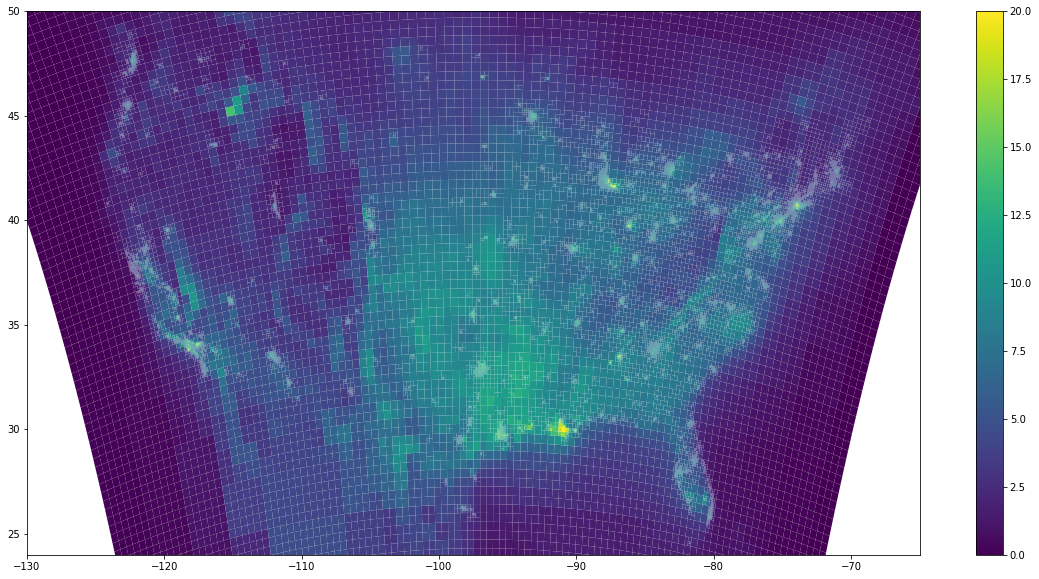

In [15]:
patches = []
for r in geomLL.Rectangles:
    polygon = Polygon(np.array(
        [[r.LL.X, r.LL.Y],
        [r.LR.X, r.LR.Y],
        [r.UR.X, r.UR.Y],
        [r.UL.X, r.UL.Y]]
    ), True)
    patches.append(polygon)
pc = PatchCollection(patches, alpha=1)
pc.set_array(np.clip(conc.Data, 0, 20)) # Clip values so it's easier to see (not generally recommended).

fig, ax = plt.subplots(figsize=(20,10))

#m = Basemap(resolution='c', # c, l, i, h, f or None
#            projection='lcc',
#            lat_0=40, lon_0=-97,
#            width=444*12000, height=336*12000)
#m.drawcoastlines() # I'm not quite sure how to get the coastlines to line up correctly (recommendations welcome).

ax.add_collection(pc)

fig.colorbar(pc, ax=ax)

ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)